# Stream active learning cycle
This Notebook displayes an example of an active learning clyce for the stream strategies implemented in this project. It also is used to better understand and display each strategie in comparrision to one another for a given Data set.

In [1]:
import sys
sys.path.append('../..')

import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy
from collections import deque
from skactiveml.classifier import PWC
from skactiveml.stream import RandomSampler, PeriodicSampler
from skactiveml.stream import FixedUncertainty, VariableUncertainty, Split, PAL
from skactiveml.stream.budget_manager import FixedBudget

## Initialize random seed
Before the strategy process can start some variables need to be Initialized.
Parameters that are alwayes needed are a random_state outsinde the Notebook are
random_state is used to fix the random seed, such that experiments are reapetable

The parameters init_train_length ,stream_length and training_size are only needed in this Notebook to generate the Dataset and determin the steam length.
init_train_length describes our training size that is used to learn the chosen classifier before starting the cycle.
stream_length is used to define a data range in that the cylce should operate.
training_size determines the queue size in which the aquiered data will be saved in.

In [2]:
random_state = np.random.RandomState(0)
init_train_length = 10
stream_length = 10000
training_size = 1000

## Initialize random seed
This next method will be used to get the same random state for all strategies to Compare them in ther decision making for the same instances.

In [3]:
def get_randomseed(random_state):
    random_state.randint(2**31-1)

## Generate and Initialize Data set
The next block Initializes all date needed for the query strategies. 
sklearn is used to generate a random dataset with our pre defined sample size and random_state
X represents the Dataset that the aktive learning stategies habe to work on.
y represents the class of each Data in X.
X_init and y_init are used to split the training data out of the steam data.
X_steam and y_steam are the Data steam used in the learning cylce.

In [4]:
X, y = sklearn.datasets.make_classification(n_samples=init_train_length + stream_length, random_state=get_randomseed(random_state), shuffle=True)
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

## Initialize query strategies
Next the query strategies will be saved in a dictionary and later on parsed through so each strategy will be used. Since some strategies need a classifier the classifier will also be initialized.
clf_factory is a factory to generate the classifier for each stragetie.
query_strategies is the dictionary of all query strategies that should be used in the cycle.

In [5]:
clf_factory = lambda: PWC(classes=[0,1], random_state=get_randomseed(random_state))
query_strategies = {
    'RandomSampler': RandomSampler(random_state=get_randomseed(random_state)),
    'PeriodicSampler': PeriodicSampler(random_state=get_randomseed(random_state)),
    'FixedUncertainty': FixedUncertainty(clf=clf_factory(), random_state=get_randomseed(random_state)),
    'VariableUncertainty': VariableUncertainty(clf=clf_factory(), random_state=get_randomseed(random_state)),
    'Split': Split(clf=clf_factory(), random_state=get_randomseed(random_state)),
    'PAL': PAL(clf=clf_factory(), random_state=get_randomseed(random_state))
}

## Start the active learning cycle
The query cycle will start by going through each strategy and learn the classifier with the training data. After the classifier is trained the stream will start. Each datapoint will be used as a candidate. The accuracy of the classifier will be determined and saved after each canditate. After each stream finished the commplete accuracy will be displayed. Lastly a plot will be displayed that shows the accuracy over all data points in comparison to the other strategies. To display and decide the accuracy a new parameter called correct_classifications will be used. It compares the prediction of the classifier for the data to the actual class.

Query Strategy:  RandomSampler Accuracy:  0.8268
Query Strategy:  PeriodicSampler Accuracy:  0.8234
Query Strategy:  FixedUncertainty Accuracy:  0.8509
Query Strategy:  VariableUncertainty Accuracy:  0.8421
Query Strategy:  Split Accuracy:  0.8436
Query Strategy:  PAL Accuracy:  0.854


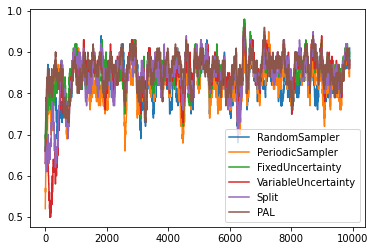

In [6]:
for query_strategy_name, query_strategy in query_strategies.items():
    clf = clf_factory()
    X_train = deque(maxlen=training_size)
    X_train.extend(X_init)
    y_train = deque(maxlen=training_size)
    y_train.extend(y_init)
    clf.fit(X_train, y_train)
    correct_classifications = []
    for t, (x_t, y_t) in enumerate(zip(X_stream, y_stream)):
        correct_classifications.append(clf.predict(x_t.reshape([1, -1]))[0] == y_t)
        sampled_indices = query_strategy.query(x_t.reshape([1, -1]), X=X_train, y=y_train)
        if len(sampled_indices):
            X_train.append(x_t)
            y_train.append(y_t)
            clf.fit(X_train, y_train)
    print("Query Strategy: ", query_strategy_name, ", Avg Accuracy: ", np.sum(correct_classifications)/stream_length)
    cumsum_correct_classifications = np.cumsum(correct_classifications)
    smoothing_window_length = 100
    plt.plot((cumsum_correct_classifications[smoothing_window_length:]-cumsum_correct_classifications[:-smoothing_window_length])/smoothing_window_length, label=query_strategy_name)
plt.legend()